## CS328 Assignment 1: Step Count Detection and Analysis

In this assignment, we'll focus on step count detection using data from wearable devices like smartwatches. 

Our goal is to develop an algorithm to count steps from raw accelerometer data. We'll implement functions for preprocessing data, identifying steps, and evaluating step detection accuracy.

By the end of this assignment, you will be able to:
1. Implement data preprocessing techniques, such as calculating acceleration magnitude and applying a low-pass filter.
2. Identify steps from processed data using peak detection.
3. Evaluate the performance of the step detection algorithm and adjust parameters to minimize errors.

This knowledge is vital for anyone interested in mobile health applications, including physical activity tracking, gait analysis, and fall detection. Mastering these skills will open doors to many opportunities in the mobile health sensing field.

#### Imports Block

Make sure all imports are in this block below (and leave the two comments IMPORTS START and IMPORT END as is. The extractor script uses the START and END delimitors when extracting the functions).

In [91]:
# -- IMPORTS START --
import matplotlib
import matplotlib.pyplot as plt

import os
import re
import warnings
import datetime
import pathlib
import glob
import numpy as np
import pandas as pd
import joblib
from scipy import signal
from sklearn import metrics

from scipy.signal import butter, filtfilt, find_peaks
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

### Helper Function: plot_step_and_nostep_windows (do not modify)

This function plots a few random windows from the accelerometer data for visualization. It can help you inspect the acceleration waveform and validate that steps are being properly identified by the peak detection.

It takes as input:
- data - pandas DataFrame containing the accelerometer data
- window_sec - length of each window in seconds
- sample_rate - sampling frequency of the data

In [92]:
def plot_step_and_nostep_windows(data,window_sec,sample_rate):
    STEPTOL = 3  # at least this many steps in a window to count as walking
    WINDOW_LEN = int(window_sec * sample_rate)  # ticks

    NFIGS_WALK = 6  # walk windows to plot
    NFIGS_NOTWALK = 3  # non-walk windows to plot
    NFIGS = NFIGS_WALK + NFIGS_NOTWALK
    NROWS = 3
    NCOLS = NFIGS // NROWS
    
    # Set number of windows 
    NUM_WINDOWS = 6

    # Generate datetime index
    start = pd.Timestamp('2023-01-01')
    delta = pd.Timedelta(seconds=1/sample_rate)  
    index = [start + i*delta for i in range(len(data))]
    data.index = index

    fig, axs = plt.subplots(ncols=3, nrows=2)

    for i in range(NUM_WINDOWS):

        # Select random window
        start = np.random.randint(0, len(data) - WINDOW_LEN)
        end = start + WINDOW_LEN
        window = data.iloc[start:end]

        ax = axs.flat[i]

        # Plot data
        ax.set_xticklabels([])        
        ax.plot(window.index, window['filtered_accel_mag'], label='Accel')

        # Plot peaks
        peak_mask = window['peaks'] != 0
        ax.plot(window.index[peak_mask], window['filtered_accel_mag'][peak_mask], 'ro', label='Peaks')

        ax.legend()
        ax.set_title(f"Random Window {i+1}")

    fig.tight_layout()
    fig.show()

### Assignment Function 1: calc_magnitude(data)

**Instructions:**
- Define a function `calc_magnitude` that takes in a DataFrame `data` as an argument.
- Add a new column to the DataFrame `data`, named 'accel_mag', which is the magnitude of the acceleration calculated using the x, y, and z accelerometer values.
- Subtract the mean of 'accel_mag' from 'accel_mag' to remove the effect of gravity and store the result in 'accel_mag'.
- The function should return the DataFrame `data`.

**Hints:**
- You can add a new column to a DataFrame using the syntax: `df['new_column'] = values`
- You can calculate the mean of a DataFrame column using the function: `df['column'].mean()`
- The function can modify the input DataFrame `data` directly (you do not need to create a new DataFrame)

In [93]:
def calc_magnitude(data):

    # Ensuring required colums exist

    req_cols = ['x', 'y', 'z']
    if not set(req_cols).issubset(data.columns):
        raise ValueError(f"Data is missing the required columns: {req_cols}")

    # Calculating the magnitude using the function  ----  sqrt(x^2 + y^2 + z^2)
    data['accel_mag'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

    # Subtracting the mean from the newly found magnitude to center the data (around 0)
    data['accel_mag'] = data['accel_mag'] - data['accel_mag'].mean()

    return data

### Assignment Function 2: remove_noise(data, sampling_rate)

**Instructions:**
- Define a function `remove_noise` that takes in a DataFrame `data` and a `sampling_rate` as arguments.
- Implement a low-pass Butterworth filter with a cutoff frequency of 5 Hz and an order of 2 to filter the accelerometer data.
- Apply the filter to the 'accel_mag' column of the DataFrame `data` and store the result in a new column named 'filtered_accel_mag'.
- The function should return the DataFrame `data`.

**Hint:** Use `scipy.signal.butter` to create the Butterworth filter and `scipy.signal.filtfilt` to apply it to your data. The function can modify the input DataFrame `data` directly (you do not need to create a new DataFrame)

In [94]:
def remove_noise(data,sampling_rate):
    
    # Defining the Butterworth filter requirements
    cutoff_freq = 5    # in hz
    order = 2           # filter order

    # Calculating the normalized cuttoff frequency (Nyquist)
    nyquist_freq = sampling_rate / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq

    # Creating Butterworth filter
    b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)

    # Applying the filter to the DataFrame data
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])

    return data

### Assignment Function 3: findsteps(data, sampling_rate, ht, pm, dist)

**Instructions:** Define a function `findsteps` function that applies a peak detection algorithm to the acceleration data to identify individual steps. 

- The function takes as arguments: `data`: a DataFrame containing the filtered acceleration magnitude signal; `sampling_rate`: the sampling frequency of the accelerometer data; `ht`: the minimum height of a peak (*use a constant 0.1 for this assignment*); `pm`: the minimum prominence of a peak (*use a constant 0.1 for this assignment*), and `dist`: the minimum distance between peaks (*this dist is a function of sampling rate, so multiply with sampling rate to get the distance you provide to find_peaks.*)
- Use the `scipy.signal.find_peaks` function to identify peaks in the acceleration signal
- Add a new column to the DataFrame to indicate where peaks are located
- Return `data`: the input DataFrame, now with an additional column `peaks` to indicate the location of detected steps

**Hints:** The `scipy.signal.find_peaks` function can be used to detect peaks in the acceleration data. As above, the function can modify the input DataFrame `data` directly (you do not create a new DataFrame)

In [95]:
def findsteps(data,sampling_rate,ht,pm,dist):
    data['peaks']= 0
    minDistance = dist* sampling_rate
    graphPeaks, _ = find_peaks(data['filtered_accel_mag'], height=ht, prominence= pm,distance=minDistance)
    data.loc[graphPeaks, 'peaks'] =1 
    return data


### Assignment Function 4: find_best_params(data, sampling_rate, ht, pm)

**Instructions:** Define the `find_best_params` function that sweeps through a range of distance values for the peak detection algorithm and identifies the distance value that results in the lowest step count error.

- The function takes as arguments: `data`: a DataFrame containing the filtered acceleration magnitude signal and annotated step locations; `sampling_rate`: the sampling frequency of the accelerometer data `ht`: the minimum height of a peak (*use a constant 0.1 for this assignment*); `pm`: the minimum prominence of a peak (*use a constant 0.1 for this assignment*)

- The function will perform the following:
    - For each distance value in the range 0.1 to 2 in 0.1 increments:
      - Detect peaks in the acceleration signal
      - Calculate the step count error (absolute difference between detected steps and annotated steps)
      - Store the error for each distance value
    - Identify the distance value that resulted in the lowest step count error

- The function will return `best_dist`: the distance value that resulted in the lowest step count error

**Hints:** You can generate the range of distance values using the `numpy.arange` function and the `numpy.argmin` function can be used to find the index of the minimum error. Also, for debugging, try plotting the distances vs errors since you can clearly see the trend and see the minimum error point.

In [96]:
def find_best_params(data,sampling_rate,ht=0.1,pm=0.1):
    intervals= np.arange(0.1,2.1,0.1)
    error_distance_value = []
    annotated_steps= data['annotation'].sum()
    print(data.columns)
    for dist in intervals:
        peakData = findsteps(data,sampling_rate,ht,pm, dist)
        detected_steps_count = peakData['peaks'].sum()
        step_error = abs(detected_steps_count- annotated_steps)
        error_distance_value.append(step_error)
    print(len(peakData['peaks']))
    index = np.argmin(error_distance_value)
    return error_distance_value[index]
        





### Assignment Function 5: eval_accuracy (all_files, best_dist)

#### Instructions:
The `eval_accuracy` function applies the step detection algorithm to a list of accelerometer data files, calculates the step count error for each file, and prints out the results along with some statistical information about the errors.

The function will take the input:
- `all_files`: a list of filenames for the accelerometer data files
- `best_dist`: the best distance value for the peak detection algorithm

The function will perform the following:
- For each filename in `all_files`:
  - Extract the sampling rate and participant ID from the filename
  - Load the accelerometer data into a DataFrame
  - Calculate the magnitude of the acceleration signal
  - Apply the low-pass filter to the acceleration signal
  - Detect steps in the acceleration signal using the provided best distance value
  - Calculate the percentage step count error (absolute difference between detected steps and annotated steps divided by true steps multiplied by 100)
  - Append a new row to the results DataFrame with ID, sample rate, true steps, detected steps and the calculated error
- Print a formatted string of the results DataFrame without the index and with one decimal place for floats
- Print a separator line consisting of 90 '-' characters
- Print the average, standard deviation, max and min error of the results DataFrame
- Returns the results DataFrame

#### Hints:
- You can extract the sampling rate and participant ID from the filename using regular expressions (see code provided below)
- The `pandas.read_csv` function can be used to load the accelerometer data into a DataFrame
- You can use the `pandas.DataFrame.append` function to append a new row to the DataFrame. The `ignore_index=True` parameter can be used to ignore the provided index and use a new one
- You can use the `to_string` method of a DataFrame to print it as a string. The `index=False` parameter will omit the index from the string and the `float_format` parameter will control the number of decimal places for float numbers
- Use the `mean`, `std`, `max` and `min` methods of a DataFrame to compute the average, standard deviation, maximum and minimum values respectively


In [97]:
def eval_accuracy(all_files,best_dist):
    pass


### Evaluate step detection for one user (do not modify)

As you develop the step detection algorithm, it is best to start with a single dataset. The reasons to start with one dataset is that it is quicker to iterate and test changes rather than waiting for all data each time, and faster to troubleshoot/identify data issues. Work through the process end-to-end on this dataset.

The code you have been provided follows these steps:
- Load the data and extract the sampling rate
- Preprocess (filter, remove noise)
- Identify the best_dist parameter that works best
- Detect steps with peak finding with the best_dist parameter
- Visualize walk vs non-walk windows


Index(['timestamp', 'x', 'y', 'z', 'annotation', 'pid', 'accel_mag',
       'filtered_accel_mag'],
      dtype='object')
359999


/var/folders/hq/y86rfncj4dxcqqvjm0_zqf_40000gn/T/ipykernel_80524/1777915910.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


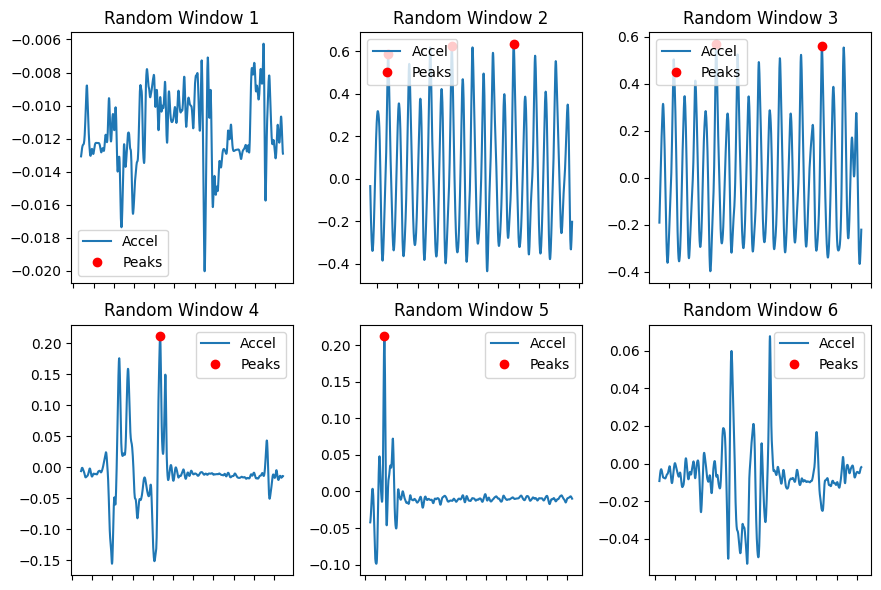

In [98]:
# First make sure the code works with just one user, say P01
filename = "./data/Steps/Wrist_100Hz/P01_wrist100.csv"

# Read the file
data = pd.read_csv(filename)

# Extract the SAMPLE_RATE from the filename using reg expression parsing
sampling_rate = int(re.search(r'(\d*)Hz', filename).group(1))

data = calc_magnitude(data)
data = remove_noise(data,sampling_rate)
best_dist = find_best_params(data,sampling_rate,0.1,0.1)
data = findsteps(data,sampling_rate,0.1,0.1,best_dist)

window_size = 10 #number of seconds to plot - upto 20 should be easy to visualize
plot_step_and_nostep_windows(data,window_size,sampling_rate)


### Assignment Table: Evaluate step detection for multiple users

Lets now check how good the best_dist parameter you obtained for one of the users (i.e. user 1 is P01, user 2 is P02 and so on) is for the entire dataset. This code does the following 1) Find the best parameters for one of the users, and 2) Get performance on all users. 

#### Fill up this table based on the results you obtain by trying different parameters (only modify the first line)
This table summarizes the step detection performance if you used the parameters you learnt from one user on all the data. **We will evaluate the accuracy of numbers you fill up below**

| Parameters learnt from | Average Error on all users |
|-|-|
| (P01, 100Hz) | 359999 |
| (P02, 100Hz) | 360000 |
| (P03, 100Hz) | 360001 |
| (P04, 100Hz) | 359999 |
| (P05, 100Hz) | 360000 |
| (P01,  25Hz) | 90000 |
| (P02,  25Hz) | 90001 |
| (P03,  25Hz) | 90000 |
| (P04,  25Hz) | 90000 |
| (P05,  25Hz) | 90000 |

In [99]:
# First, learn the best parameters for one of the users - ONLY THIS LINE NEEDS TO BE MODIFIED IN THIS BLOCK
filename = "./data/Steps/Wrist_25Hz/P05_wrist25.csv"

# Read the file
data = pd.read_csv(filename)

# Extract the SAMPLE_RATE from the filename using reg expression parsing
sampling_rate = int(re.search(r'(\d*)Hz', filename).group(1))

data = calc_magnitude(data)
data = remove_noise(data,sampling_rate)
best_dist = find_best_params(data,sampling_rate,0.1,0.1)

# Test how well the parameters work for the rest of the users
filenames_100 = glob.glob("./data/Steps/Wrist_100Hz/P*.csv")
filenames_25 = glob.glob("./data/Steps/Wrist_25Hz/P*.csv")
all_files = filenames_100 + filenames_25

results = eval_accuracy(all_files,best_dist)

Index(['timestamp', 'x', 'y', 'z', 'annotation', 'accel_mag',
       'filtered_accel_mag'],
      dtype='object')
90000


### Count steps from your own data (do not modify)

In the last step, you will use the step counter you have developed to count steps from your own data. For this:
1. Use the Sensor Logger app to record a few minutes of accelerometer data when you are walking around with the phone in your hand or pocket.
2. Copy the recorded file from Sensor Logger and store it in data/MyData/Accelerometer_100Hz.csv
3. Run the findsteps function that you wrote above. Use best_dist obtained for one of the users in previous block.
4. Plot the filtered accelerometer magnitude and the steps that you detected.

**Note: This block will not be graded based on number of steps. If the code works and steps are plotted, thats enough.**

/var/folders/hq/y86rfncj4dxcqqvjm0_zqf_40000gn/T/ipykernel_80524/1777915910.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


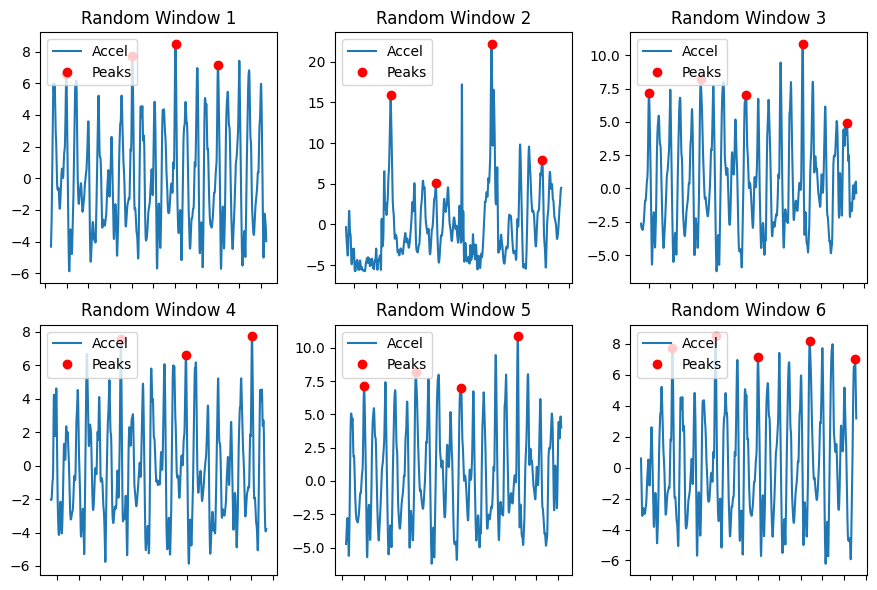

In [102]:
filename = "./data/Steps/MyData/Accelerometer_100Hz.csv"

# Read csv  
data = pd.read_csv(filename)  

data = calc_magnitude(data)
data = remove_noise(data,sampling_rate)
data = findsteps(data,sampling_rate,0.1,0.1,best_dist)

sampling_rate = 100 #Sensor Logger samples at 100Hz by default
window_size = 10 #number of seconds to plot - upto 20 should be easy to visualize
plot_step_and_nostep_windows(data,window_size,sampling_rate)
